In [1]:
import os

import torch
import torchvision

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path

from utils import random_data_visual

---

# Data

In [2]:
# Initializing a directory for the data
data_path = Path('./data/')

if not data_path.is_dir():
    os.mkdir(data_path)

In [3]:
# Getting the data from torch
train_data = torchvision.datasets.FashionMNIST(root=data_path,
                                               train=True,
                                               transform=torchvision.transforms.ToTensor(),
                                               download=True)

test_data = torchvision.datasets.FashionMNIST(root=data_path,
                                              train=False,
                                              transform=torchvision.transforms.ToTensor(),
                                              download=True)

In [4]:
# List of all the class names
class_names = train_data.classes

for i, name in enumerate(class_names):
    print(f"Index: {i}")
    print(f"Label: {name}")
    print()

Index: 0
Label: T-shirt/top

Index: 1
Label: Trouser

Index: 2
Label: Pullover

Index: 3
Label: Dress

Index: 4
Label: Coat

Index: 5
Label: Sandal

Index: 6
Label: Shirt

Index: 7
Label: Sneaker

Index: 8
Label: Bag

Index: 9
Label: Ankle boot



In [5]:
# Gathering details about the downloaded image data
img, label = train_data[0]

print(f"Image Shape : {img.shape}")
print(f"\nNumber of Inputs for Dense model: {img.shape[1] * img.shape[2]}")

Image Shape : torch.Size([1, 28, 28])

Number of Inputs for Dense model: 784


In [6]:
# Getting a list with number of datapoints for each class
label_list = [y for _, y in train_data]

label_list = pd.Series(label_list)

print(label_list.value_counts().sort_index())

0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64


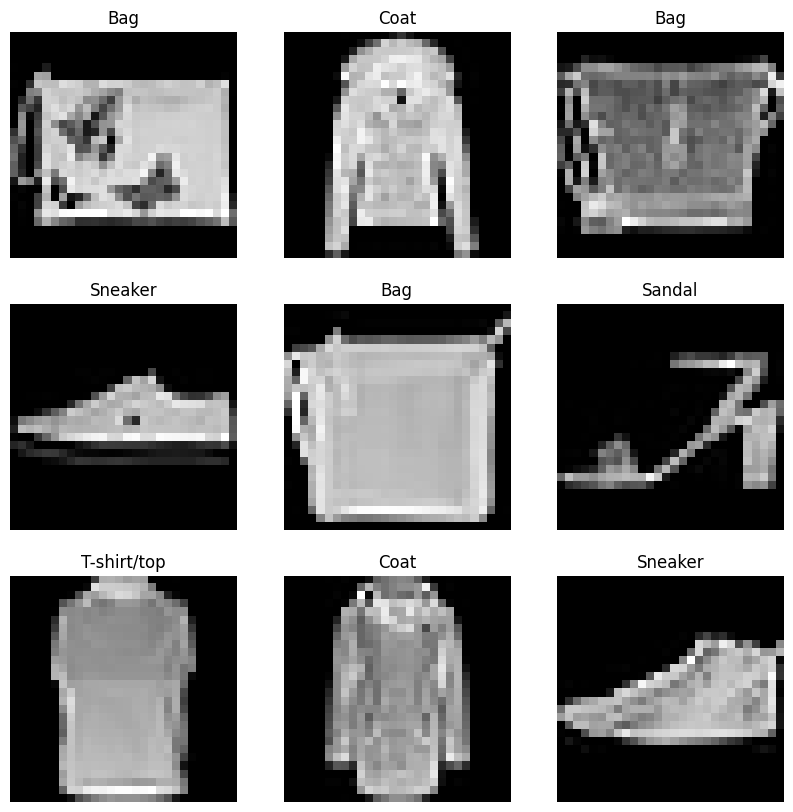

In [7]:
# Visualizing random data samples
random_data_visual(dataset=train_data, 
                   class_names=class_names)

In [8]:
# Loading the datasets to the data loader
batch_size = 32
num_workers = int(os.cpu_count()/2)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=batch_size * 2,
                              shuffle=True,
                              num_workers=num_workers)

Details:
- Image dimension---: 28 * 28
- Image color-------: Grayscale
- Image Labels------: Balanced

- No data augmentation will be done as most of the data follows a similar pattern. 
- This is to reduce the complexity of the project.
- The custom data that will be fed to the model at the end of the experimentation will also follow a similar input structure.

---

# Model